# Trabalho Prático 2
## Processamento de Linguagem Natural - 2018/2

### Bernardo de Almeida Abreu - 2018718155

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import re
import gensim
import nltk
import keras
import matplotlib.pyplot as plt
from keras.models import model_from_json

/home/bernardo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
paths = {
    'train': '../macmorpho-v3/macmorpho-train.txt',
    'test': '../macmorpho-v3/macmorpho-test.txt',
    'dev': '../macmorpho-v3/macmorpho-dev.txt',
    'word2vec': '../data/skip_s100.txt',
    'model': '../src/model.json',
    'model_weights': '../src/model.h5'
}

## Embedding - Word2Vec

In [3]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(paths['word2vec'])

In [4]:
w2v_model.similar_by_vector('hemocentro')

/home/bernardo/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hemopa', 0.8358802199363708),
 ('hemonúcleo', 0.8148629069328308),
 ('hemoal', 0.7524209022521973),
 ('hemorio', 0.7506005764007568),
 ('procon', 0.73494553565979),
 ('centrinho', 0.7315341234207153),
 ('hemoam', 0.7078859806060791),
 ('incor', 0.7009121775627136),
 ('detran', 0.7000018358230591),
 ('poupatempo', 0.6961973905563354)]

### Adiciona vetores extras

In [5]:
w2v_model.add(['<PAD>','<OOV>'], [[0.1]*100,[0.2]*100])

In [6]:
print('<PAD>' in w2v_model)

True


## Leitura do texto

In [7]:
def read_text(filename):
    with open(filename, 'r') as f:
        return f.readlines()

In [8]:
train_text = read_text(paths['train'])
test_text = read_text(paths['test'])
dev_text = read_text(paths['dev'])

print(train_text[0])
print(test_text[0])
print(dev_text[0])

Jersei_N atinge_V média_N de_PREP Cr$_CUR 1,4_NUM milhão_N na_PREP+ART venda_N da_PREP+ART Pinhal_NPROP em_PREP São_NPROP Paulo_NPROP ._PU

Salto_N sete_ADJ

Ainda_ADV em_PREP dezembro_N de_PREP 1990_N ,_PU foi_V editada_PCP a_ART famosa_ADJ 289_N ,_PU que_PRO-KS modificava_V a_ART sistemática_N da_PREP+ART arrecadação_N do_PREP+ART ITR_NPROP e_KC alterava_V suas_PROADJ alíquotas_N ._PU



### Separação de palavras e tags

In [9]:
def split_word_tags(text):
    word_lines = []
    tag_lines = []
    for line in text:
        words, tags = zip(*[tagged_word.split('_') for tagged_word in line.split()])
        word_lines.append([w.lower() for w in words])
        tag_lines.append(list(tags))
    return word_lines, tag_lines

In [10]:
train_words, train_tags = split_word_tags(train_text)
print(train_words[0])
print(train_tags[0])

test_words, test_tags = split_word_tags(test_text)
dev_words, dev_tags = split_word_tags(dev_text)


['jersei', 'atinge', 'média', 'de', 'cr$', '1,4', 'milhão', 'na', 'venda', 'da', 'pinhal', 'em', 'são', 'paulo', '.']
['N', 'V', 'N', 'PREP', 'CUR', 'NUM', 'N', 'PREP+ART', 'N', 'PREP+ART', 'NPROP', 'PREP', 'NPROP', 'NPROP', 'PU']


In [11]:
def flat_list(l):
    return [item for sublist in l for item in sublist]
len(set(flat_list(train_words)))

id2tag = ['<PAD>'] + list(set(flat_list(train_tags)).union(set(flat_list(test_tags))).union(set(flat_list(dev_tags))))
tag2id = {}
for i, tag in enumerate(id2tag):
    tag2id[tag] = i
print(tag2id)
print(id2tag)

{'<PAD>': 0, 'PREP+ART': 1, 'V': 2, 'ADV': 3, 'PROADJ': 4, 'CUR': 5, 'PREP': 6, 'KC': 7, 'PREP+PRO-KS': 8, 'PROPESS': 9, 'ADJ': 10, 'PREP+PROSUB': 11, 'NPROP': 12, 'PCP': 13, 'PRO-KS': 14, 'PDEN': 15, 'PREP+PROADJ': 16, 'ART': 17, 'PREP+ADV': 18, 'PREP+PROPESS': 19, 'KS': 20, 'NUM': 21, 'ADV-KS': 22, 'PROSUB': 23, 'IN': 24, 'N': 25, 'PU': 26}
['<PAD>', 'PREP+ART', 'V', 'ADV', 'PROADJ', 'CUR', 'PREP', 'KC', 'PREP+PRO-KS', 'PROPESS', 'ADJ', 'PREP+PROSUB', 'NPROP', 'PCP', 'PRO-KS', 'PDEN', 'PREP+PROADJ', 'ART', 'PREP+ADV', 'PREP+PROPESS', 'KS', 'NUM', 'ADV-KS', 'PROSUB', 'IN', 'N', 'PU']


## Pad the words

### Analyse sentence size distribution

In [12]:
df_train = pd.DataFrame(columns=['words', 'tags'])
df_test = pd.DataFrame(columns=['words', 'tags'])
df_dev = pd.DataFrame(columns=['words', 'tags'])

df_train['words'] = train_words
df_train['tags'] = train_tags

df_test['words'] = test_words
df_test['tags'] = test_tags

df_dev['words'] = dev_words
df_dev['tags'] = dev_tags



df_sentences = pd.concat([df_train, df_test, df_dev], axis=0)

df_sentences.shape

(49932, 2)

In [13]:
df_sentences['words'].map(len).describe()

count    49932.000000
mean        18.940779
std         12.070051
min          1.000000
25%         10.000000
50%         17.000000
75%         25.000000
max        248.000000
Name: words, dtype: float64

<IPython.core.display.Javascript object>


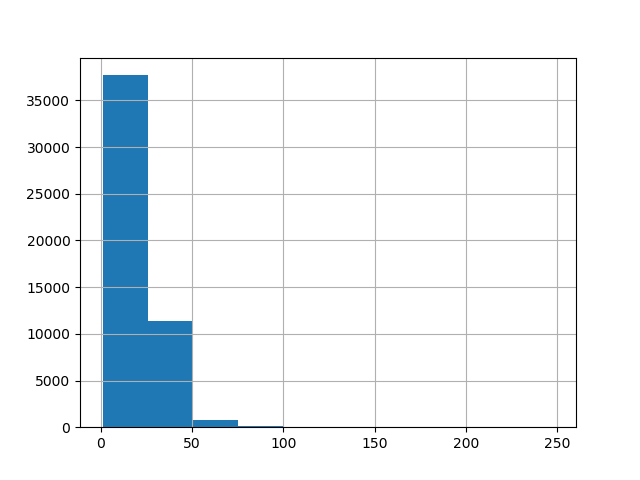

In [14]:
df_sentences['words'].map(len).hist()
plt.show()

In [15]:
MAX_SENTENCE_LENGTH = int(df_sentences['words'].map(len).describe()['75%'])
MAX_SENTENCE_LENGTH

25

In [16]:
def fill_sentence(sentence):
    tokens_to_fill = int(MAX_SENTENCE_LENGTH - len(sentence))
    
#     sentence.append('<END>')
    sentence.extend(['<PAD>']*tokens_to_fill)
    
    return sentence[:MAX_SENTENCE_LENGTH]

In [17]:
df_train["words"] = df_train["words"].map(fill_sentence)
df_train["tags"] = df_train["tags"].map(fill_sentence)

df_test["words"] = df_test["words"].map(fill_sentence)
df_test["tags"] = df_test["tags"].map(fill_sentence)

df_dev["words"] = df_dev["words"].map(fill_sentence)
df_dev["tags"] = df_dev["tags"].map(fill_sentence)

In [18]:
df_test.head()

,words,tags
0,"[salto, sete, <PAD>, <PAD>, <PAD>, <PAD>, <PAD...","[N, ADJ, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <P..."
1,"[o, grande, assunto, da, semana, em, nova, yor...","[ART, ADJ, N, PREP+ART, N, PREP, NPROP, NPROP,..."
2,"[número, duplo, especial, ,, é, inteirinho, de...","[N, ADJ, ADJ, PU, V, ADJ, PCP, PREP, N, PREP, ..."
3,"[a, endiabrada, editora, tina, brown, ex, da, ...","[ART, PCP, N, NPROP, NPROP, N, PREP+ART, PU, N..."
4,"[além, das, fotos, de, richard, avedon, ., <PA...","[PREP, PREP+ART, N, PREP, NPROP, NPROP, PU, <P..."


In [19]:
df_dev['words'].map(len).describe()

count    1997.0
mean       25.0
std         0.0
min        25.0
25%        25.0
50%        25.0
75%        25.0
max        25.0
Name: words, dtype: float64

In [20]:
print(len(w2v_model.vocab))
print(MAX_SENTENCE_LENGTH)
print(len(df_train))
w2v_model.vocab['<OOV>'].index
print(len(df_train['words']))

929608
25
37948
37948


In [21]:
pretrained_weights = w2v_model.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)

def word2idx(word):
    return w2v_model.vocab[word].index
def idx2word(idx):
    return w2v_model.index2word[idx]


def prepare_words(sentences):
    sentences_x = np.zeros([len(sentences), MAX_SENTENCE_LENGTH], dtype=np.int32)

    oov_index = word2idx('<OOV>')
    for i, sentence in enumerate(sentences):
        for t, word in enumerate(sentence):
            try:
                sentences_x[i, t] = word2idx(word)
            except KeyError:
                sentences_x[i, t] = oov_index
    return sentences_x

def prepare_tags(tag_sentences, tag2index):
    tags_y = np.zeros([len(tag_sentences), MAX_SENTENCE_LENGTH], dtype=np.int32)
    for i, sentence in enumerate(tag_sentences):
        for t, tag in enumerate(sentence):
            tags_y[i, t] = tag2index[tag]
    return tags_y


Result embedding shape: (929608, 100)


In [22]:
print('\nPreparing the train data for LSTM...')
train_sentences_X = prepare_words(df_train['words'])
print('train_x shape:', train_sentences_X.shape)

print('\nPreparing the test data for LSTM...')
test_sentences_X = prepare_words(df_test['words'])
print('test_x shape:', test_sentences_X.shape)

print('\nPreparing the validation data for LSTM...')
dev_sentences_X = prepare_words(df_dev['words'])
print('dev_x shape:', dev_sentences_X.shape)


print('\nPreparing the train tags for LSTM...')
train_tags_y = prepare_tags(df_train['tags'], tag2id)
print('train_y shape:', train_tags_y.shape)

print('\nPreparing the test data for LSTM...')
test_tags_y = prepare_tags(df_test['tags'], tag2id)
print('test_y shape:', test_tags_y.shape)

print('\nPreparing the validation data for LSTM...')
dev_tags_y = prepare_tags(df_dev['tags'], tag2id)
print('dev_y shape:', dev_tags_y.shape)

print()

print(train_sentences_X[0])
print(test_sentences_X[0])
print(dev_sentences_X[0])
print(train_tags_y[0])
print(test_tags_y[0])
print(dev_tags_y[0])

cat_train_tags_y = keras.utils.to_categorical(train_tags_y, num_classes=len(id2tag), dtype='int32')
cat_test_tags_y = keras.utils.to_categorical(test_tags_y, num_classes=len(id2tag), dtype='int32')
cat_dev_tags_y = keras.utils.to_categorical(dev_tags_y, num_classes=len(id2tag), dtype='int32')

# print(cat_train_tags_y[0])
print(cat_test_tags_y.shape)


Preparing the train data for LSTM...
train_x shape: (37948, 25)

Preparing the test data for LSTM...
test_x shape: (9987, 25)

Preparing the validation data for LSTM...
dev_x shape: (1997, 25)

Preparing the train tags for LSTM...
train_y shape: (37948, 25)

Preparing the test data for LSTM...
test_y shape: (9987, 25)

Preparing the validation data for LSTM...
dev_y shape: (1997, 25)

[181752   4740    563      2  26881 929607   1945     19    969      9
  18911     10     43    176      3 929606 929606 929606 929606 929606
 929606 929606 929606 929606 929606]
[  4223    640 929606 929606 929606 929606 929606 929606 929606 929606
 929606 929606 929606 929606 929606 929606 929606 929606 929606 929606
 929606 929606 929606 929606 929606]
[    62     10    304      2 929607      1     28  12671      4   3625
 929607      1      7 135781      4   8892      9   7603      8  92478
      6  65251    109  27690      3]
[25  2 25  6  5 21 25  1 25  1 12  6 12 12 26  0  0  0  0  0  0  0  0  0
 

## Arquitetura do modelo

In [42]:
model = keras.models.Sequential()
model

### Adiciona camada de embedding

In [45]:
# model.add(keras.layers.InputLayer(input_shape=(max_sentence_length, )))

In [43]:
model.add(
    keras.layers.Embedding(
        input_dim=len(w2v_model.vocab),
        output_dim=emdedding_size,
        input_length=MAX_SENTENCE_LENGTH,
        weights=[pretrained_weights]
    )
)

In [44]:
model.add(keras.layers.Bidirectional(keras.layers.LSTM(256,dropout=0.2, return_sequences=True)))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(len(tag2id))))
model.add(keras.layers.Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])
 
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           92960800  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 512)           731136    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 27)            13851     
_________________________________________________________________
activation_1 (Activation)    (None, 25, 27)            0         
Total params: 93,705,787
Trainable params: 93,705,787
Non-trainable params: 0
_________________________________________________________________


In [59]:
csv_logger = keras.callbacks.CSVLogger('training.log')
model.fit(train_sentences_X, cat_train_tags_y, batch_size=128, epochs=40,
          validation_data=(dev_sentences_X,cat_dev_tags_y),
          callbacks=[csv_logger])

Train on 37948 samples, validate on 1997 samples
Epoch 1/40
  128/37948 [..............................] - ETA: 18:10 - loss: 0.2386 - acc: 0.9384

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_sentences_X, cat_test_tags_y)
print(f"{model.metrics_names[1]}: {scores[1] * 100}")   # acc: 99.09751977804825

## Save model

### serialize model to JSON

In [58]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### serialize weights to HDF5

In [ ]:
model.save_weights("model.h5")
print("Saved model to disk")

## Load model

### load json and create model

In [23]:
json_file = open(paths['model'], 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

### load weights into new model

In [24]:
loaded_model.load_weights(paths['model_weights'])
print("Loaded model from disk")

Loaded model from disk


### evaluate loaded model on test data

In [27]:
loaded_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

In [ ]:
score = loaded_model.evaluate(train_sentences_X, cat_train_tags_y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))